In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.tsa.stattools import coint

In [12]:
btc = pd.read_csv("../BTC_data.csv", parse_dates=["date"], index_col="date")
eth = pd.read_csv("../ETH_data.csv", parse_dates=["date"], index_col="date")

In [13]:
pair_df = (
    btc[["log_price", "y_log_ret_1d_next"]]
    .rename(columns={
        "log_price": "btc_log_price",
        "y_log_ret_1d_next": "btc_y_log_ret_1d_next",
    })
    .join(
        eth[["log_price", "y_log_ret_1d_next"]]
        .rename(columns={
            "log_price": "eth_log_price",
            "y_log_ret_1d_next": "eth_y_log_ret_1d_next",
        }),
        how="inner"
    )
    .dropna()
)

print("Pair df shape:", pair_df.shape)
print(pair_df.head())

Pair df shape: (3177, 4)
            btc_log_price  btc_y_log_ret_1d_next  eth_log_price  \
date                                                              
2017-03-15       7.130587              -0.050720       3.560478   
2017-03-16       7.079867              -0.076592       3.817932   
2017-03-17       7.003275              -0.122050       3.795040   
2017-03-18       6.881224               0.062612       3.526361   
2017-03-19       6.943836               0.016729       3.763987   

            eth_y_log_ret_1d_next  
date                               
2017-03-15               0.257454  
2017-03-16              -0.022892  
2017-03-17              -0.268679  
2017-03-18               0.237626  
2017-03-19              -0.014248  


In [14]:
print("Correlation between BTC and ETH next-day returns:")
print(pair_df[["btc_y_log_ret_1d_next", "eth_y_log_ret_1d_next"]].corr())

print("\nCorrelation between BTC and ETH log prices:")
print(pair_df[["btc_log_price", "eth_log_price"]].corr())


Correlation between BTC and ETH next-day returns:
                       btc_y_log_ret_1d_next  eth_y_log_ret_1d_next
btc_y_log_ret_1d_next               1.000000               0.739818
eth_y_log_ret_1d_next               0.739818               1.000000

Correlation between BTC and ETH log prices:
               btc_log_price  eth_log_price
btc_log_price       1.000000       0.925857
eth_log_price       0.925857       1.000000


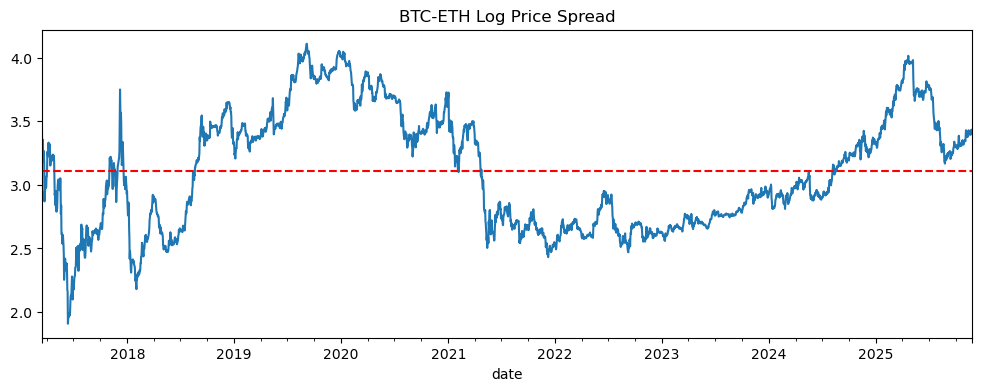

count    3177.000000
mean        3.107282
std         0.460572
min         1.907918
25%         2.689978
50%         3.024158
75%         3.462625
max         4.109520
Name: spread, dtype: float64


In [15]:
pair_df["spread"] = pair_df["btc_log_price"] - pair_df["eth_log_price"]

pair_df["spread"].plot(figsize=(12,4))
plt.title("BTC-ETH Log Price Spread")
plt.axhline(pair_df["spread"].mean(), linestyle="--", color="red")
plt.show()

print(pair_df["spread"].describe())

In [16]:
score, pvalue, _ = coint(pair_df["btc_log_price"], pair_df["eth_log_price"])
print("Cointegration p-value:", pvalue)


Cointegration p-value: 0.357284821504267


Step 2 summary:
- Z-score window: 60 days
- Z-score non-NaN count: 3118


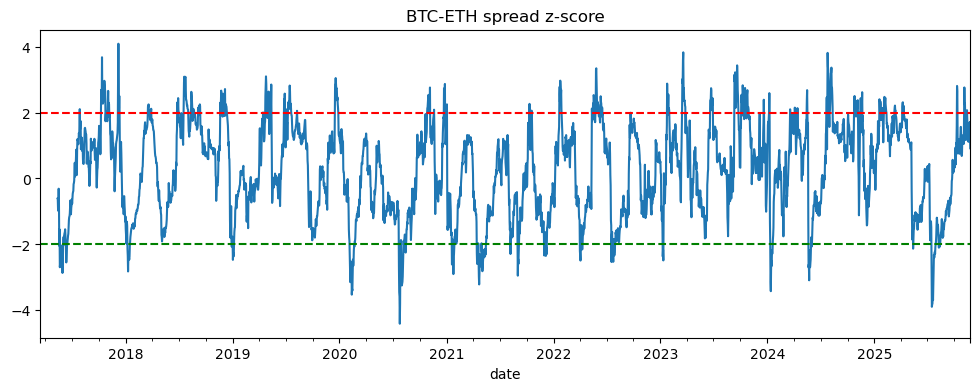

In [17]:
window = 60  

spread = pair_df["spread"]

roll_mean = spread.rolling(window).mean()
roll_std  = spread.rolling(window).std()

pair_df["spread_z"] = (spread - roll_mean) / roll_std

print("Step 2 summary:")
print(f"- Z-score window: {window} days")
print(f"- Z-score non-NaN count: {pair_df['spread_z'].dropna().shape[0]}")

pair_df["spread_z"].plot(figsize=(12, 4))
plt.axhline( 2, linestyle="--", color="red")
plt.axhline(-2, linestyle="--", color="green")
plt.title("BTC-ETH spread z-score")
plt.show()


In [18]:
print("mean z:", pair_df["spread_z"].mean())
print("P(z > 0):", (pair_df["spread_z"] > 0).mean())
print("P(z > 2):", (pair_df["spread_z"] > 2).mean())
print("P(z < -2):", (pair_df["spread_z"] < -2).mean())


mean z: 0.2619008021514401
P(z > 0): 0.5659427132514951
P(z > 2): 0.10261252754170601
P(z < -2): 0.05476864966949953


Backtest summary:
- Start date: 2017-03-16
- End date:   2025-11-24
- Mean daily return: 0.000087
- Daily vol:        0.026507
- Sharpe (252d):    0.05
- Trades (non-zero days): 2120


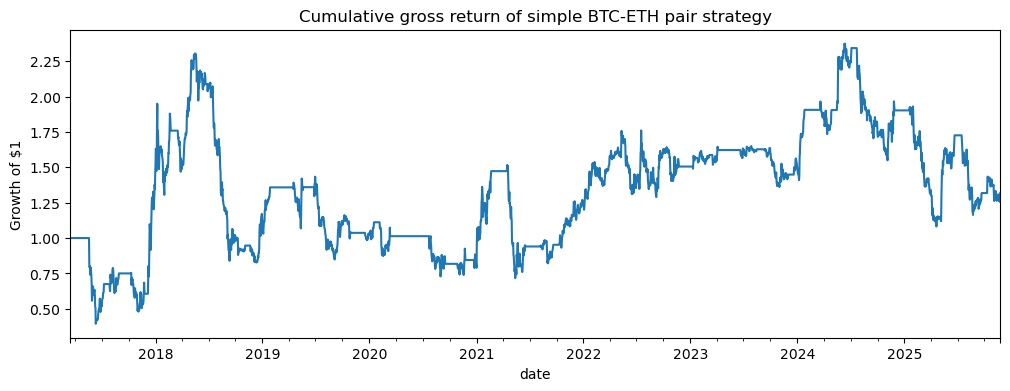

In [19]:
upper = 2.0    
lower = -2.0    
exit_th = 0.1   

z = pair_df["spread_z"].copy()


raw_sig = pd.Series(0, index=z.index)
raw_sig[z > upper] = -1   
raw_sig[z < lower] =  1   


position = raw_sig.copy()
for i in range(1, len(position)):
    if position.iloc[i] == 0:
        if abs(z.iloc[i]) < exit_th:
            position.iloc[i] = 0
        else:
            position.iloc[i] = position.iloc[i-1]

pair_df["position"] = position

pos_shifted = pair_df["position"].shift(1)

pair_ret = pos_shifted * (
    pair_df["btc_y_log_ret_1d_next"] - pair_df["eth_y_log_ret_1d_next"]
)
pair_df["pair_ret"] = pair_ret


valid = pair_ret.dropna()
cum_ret = valid.cumsum().apply(np.exp)  
sharpe = valid.mean() / valid.std() * np.sqrt(252)

print("Backtest summary:")
print(f"- Start date: {valid.index.min().date()}")
print(f"- End date:   {valid.index.max().date()}")
print(f"- Mean daily return: {valid.mean():.6f}")
print(f"- Daily vol:        {valid.std():.6f}")
print(f"- Sharpe (252d):    {sharpe:.2f}")
print(f"- Trades (non-zero days): {(pair_df['position'] != 0).sum()}")

cum_ret.plot(figsize=(12, 4))
plt.title("Cumulative gross return of simple BTC-ETH pair strategy")
plt.ylabel("Growth of $1")
plt.show()
